# Predicting Toronto Ferry Activity

In [1]:
from Model import Model 
import pandas as pd 

In [2]:
def load_data(file):
    # generic data processing function
    df = pd.read_csv(file,
                dtype={'_id':int, 'Redemption Count': int, 'Sales Count':int},
                parse_dates=['Timestamp'])
    df.sort_values('Timestamp', inplace=True)
    # convert to time-aware
    df.set_index('Timestamp', inplace=True)
    df_daily = df.resample('d').sum()
    # engineer some time features 
    df_daily['monthly'] = df_daily.reset_index().Timestamp.dt.month.values
    df_daily['quarter'] = df_daily.reset_index().Timestamp.dt.quarter.values
    return df_daily

In [3]:
df = load_data('./data/Toronto Island Ferry Ticket Counts.csv')
df.head()

,_id,Redemption Count,Sales Count,monthly,quarter
Timestamp,,,,,
2015-05-01,985694,1,4,5,2
2015-05-02,0,0,0,5,2
2015-05-03,0,0,0,5,2
2015-05-04,4681828,12,75,5,2
2015-05-05,11333457,537,549,5,2


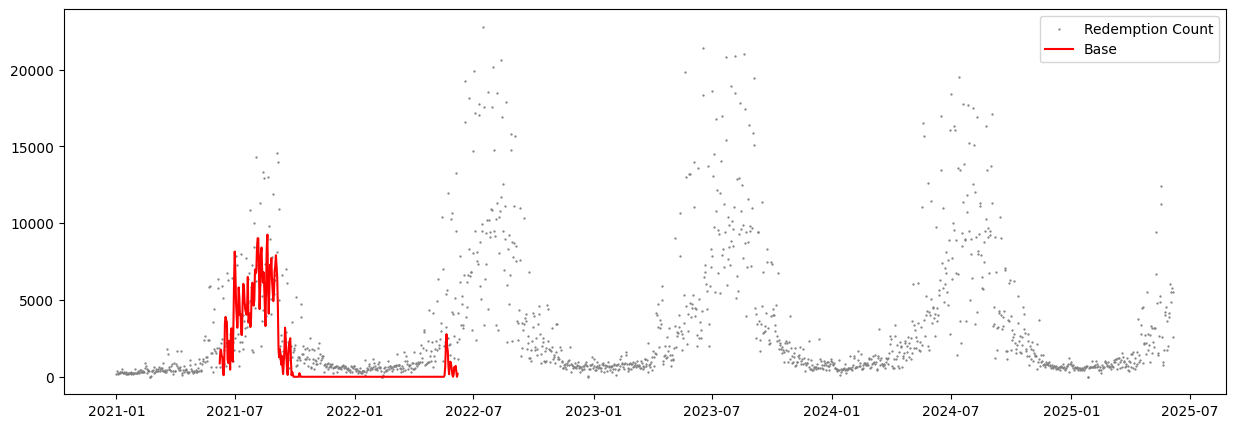

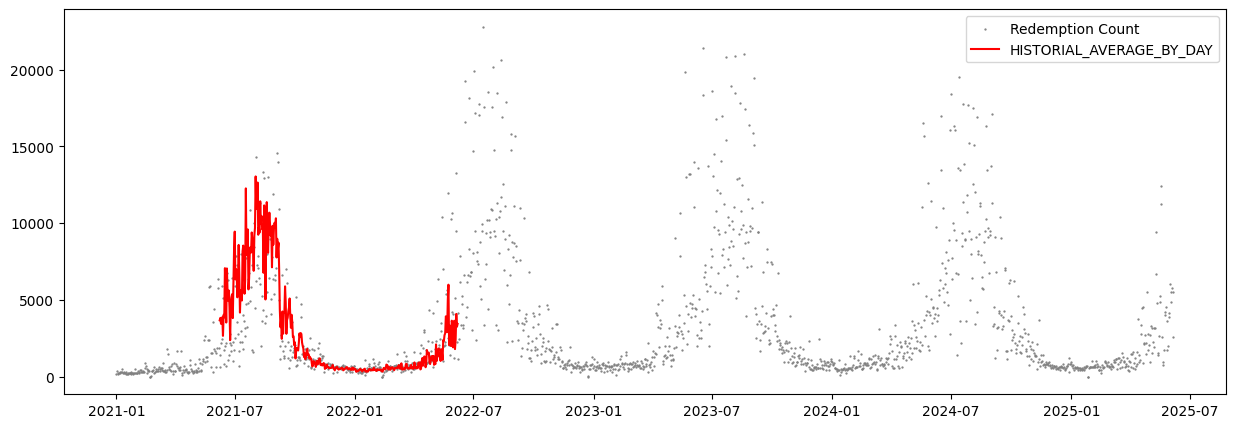

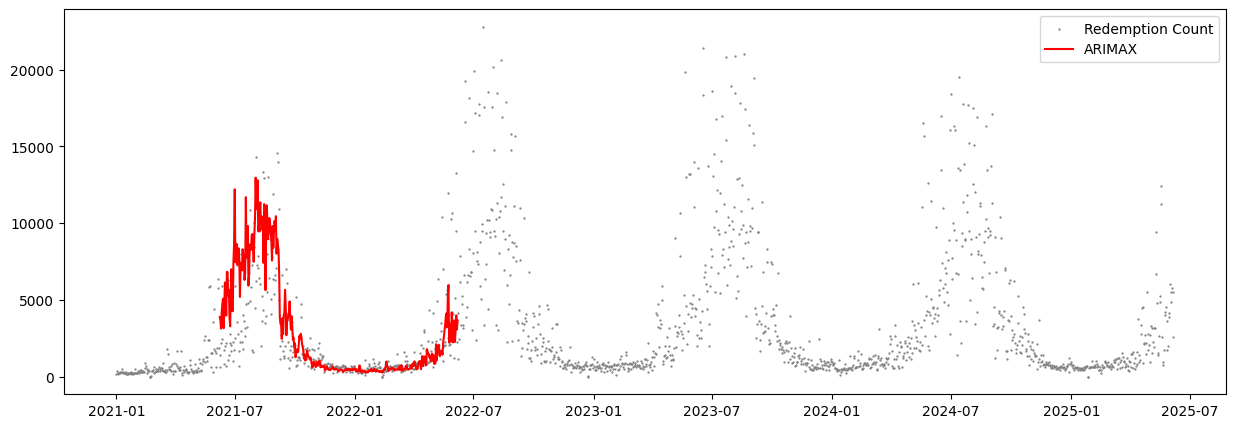

/Users/marianomaisonnave/Repositories/COMP-44081/.venv/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


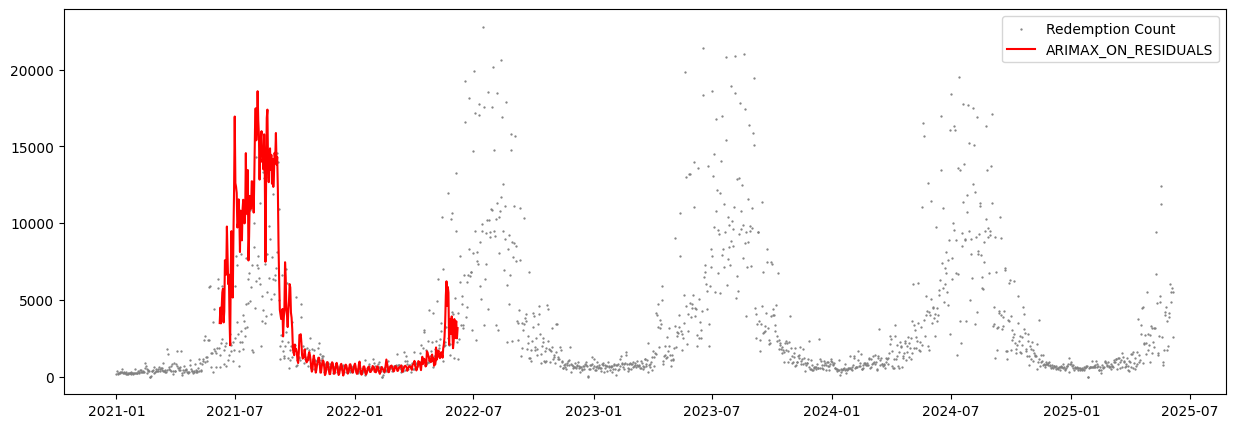

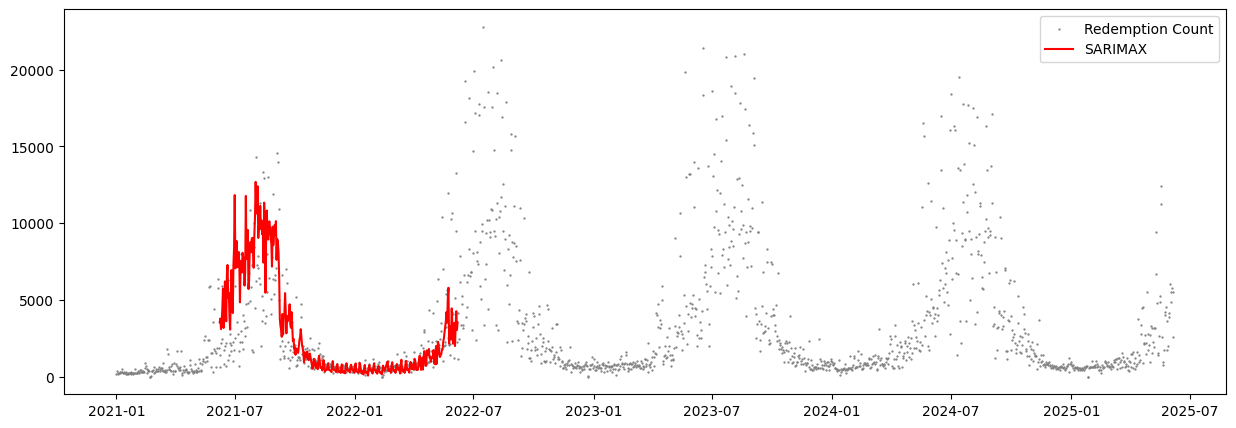

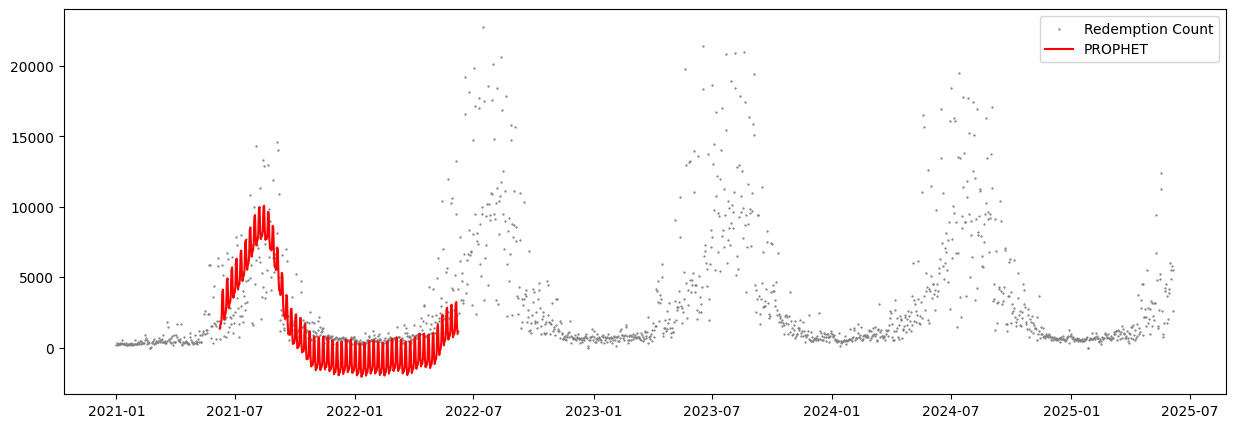

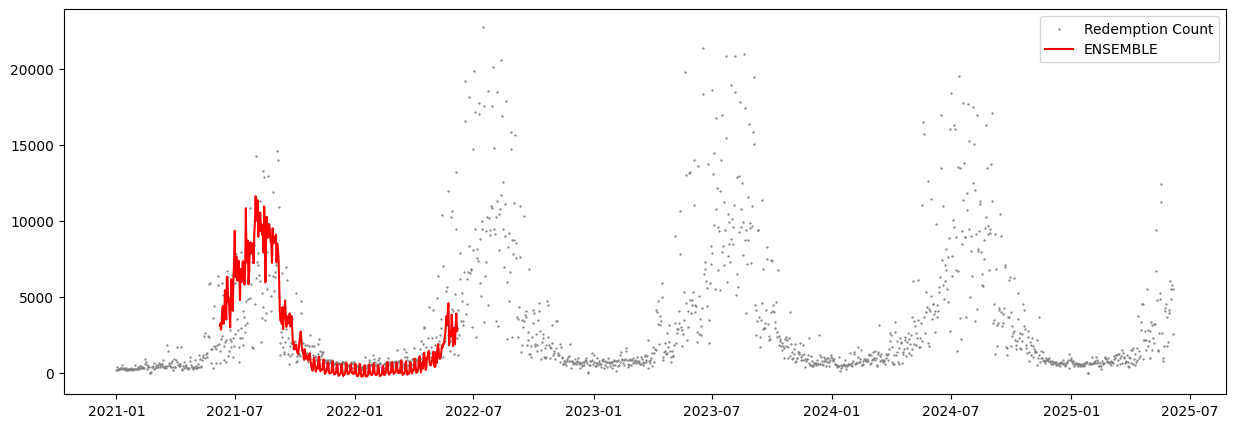

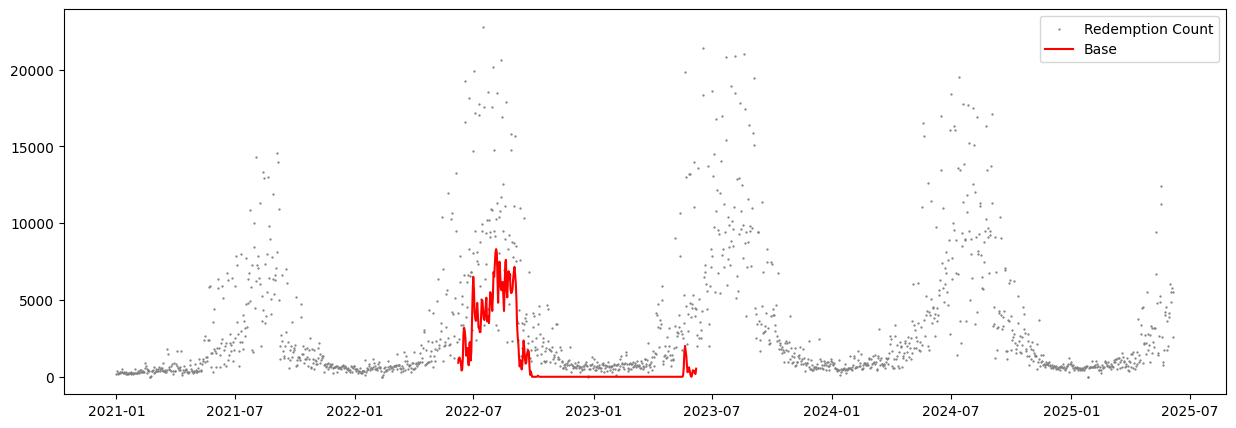

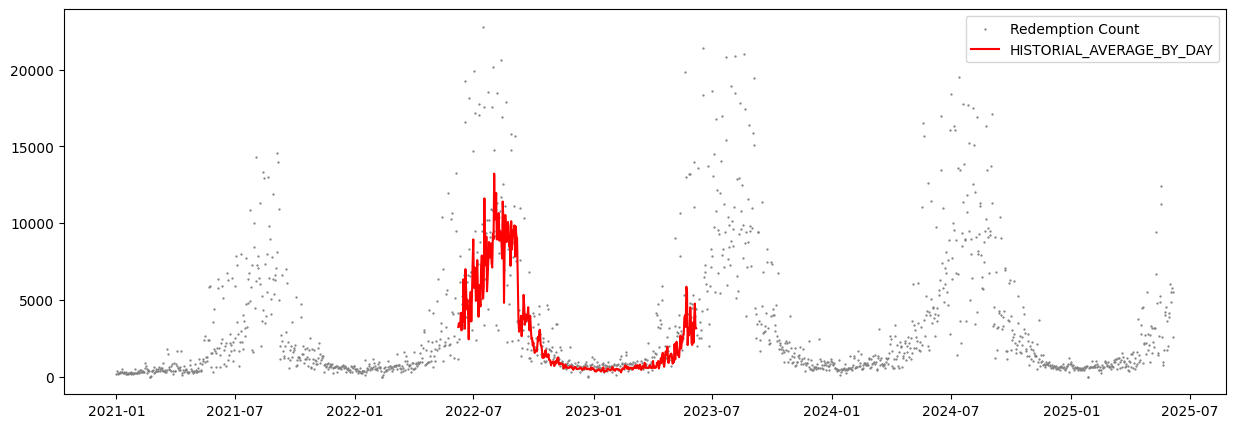

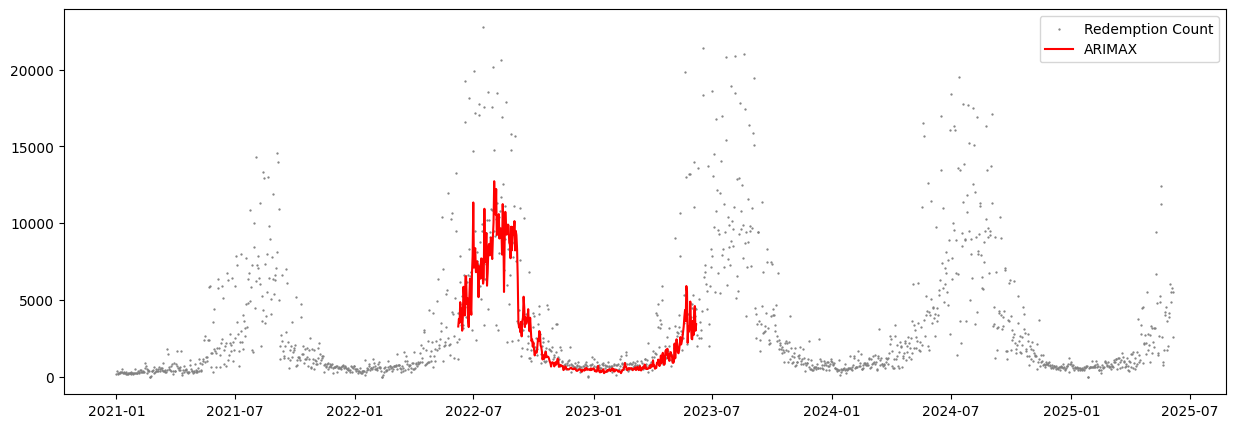

/Users/marianomaisonnave/Repositories/COMP-44081/.venv/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


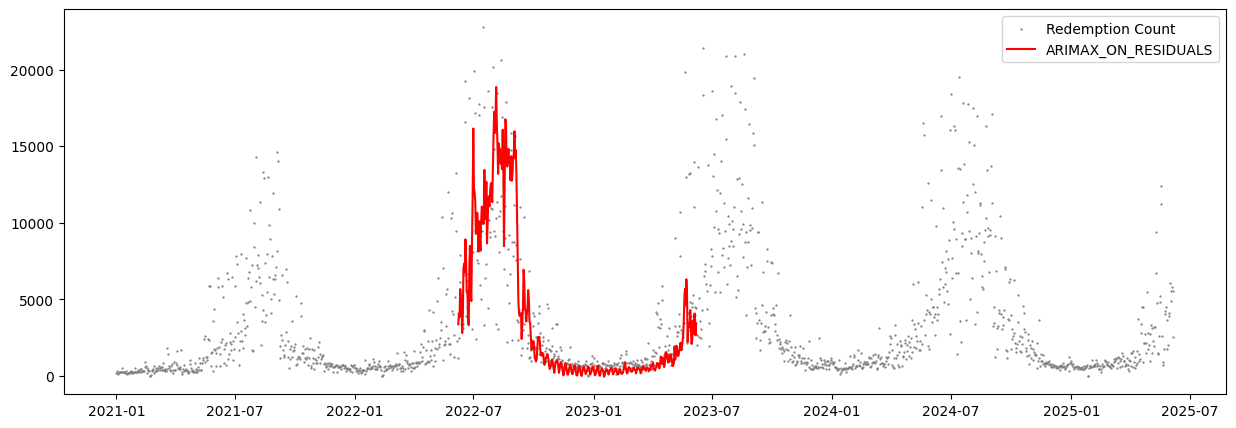

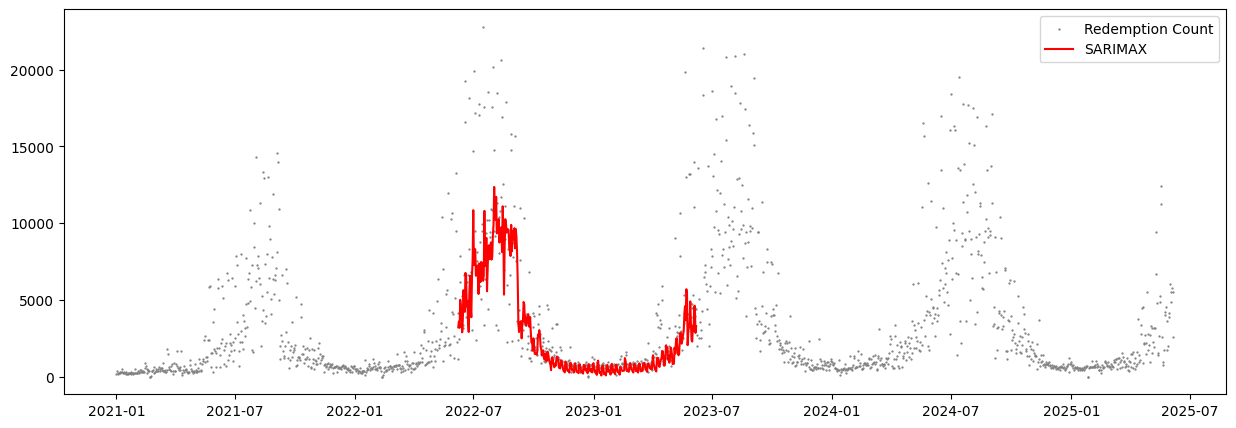

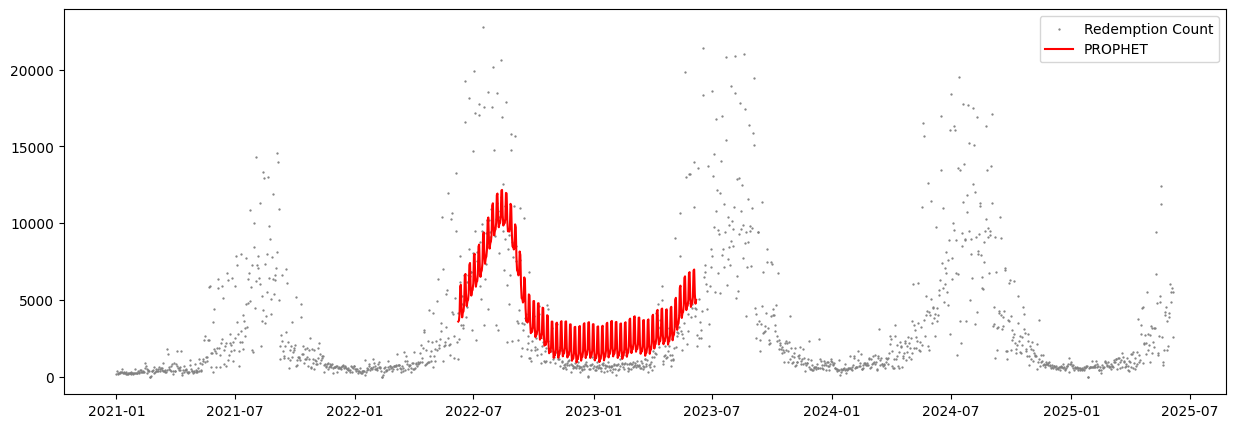

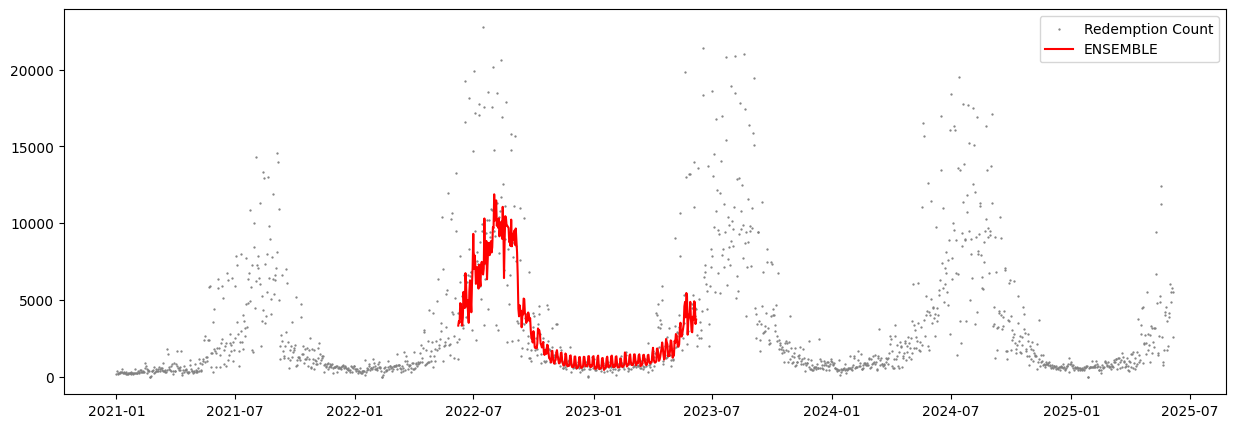

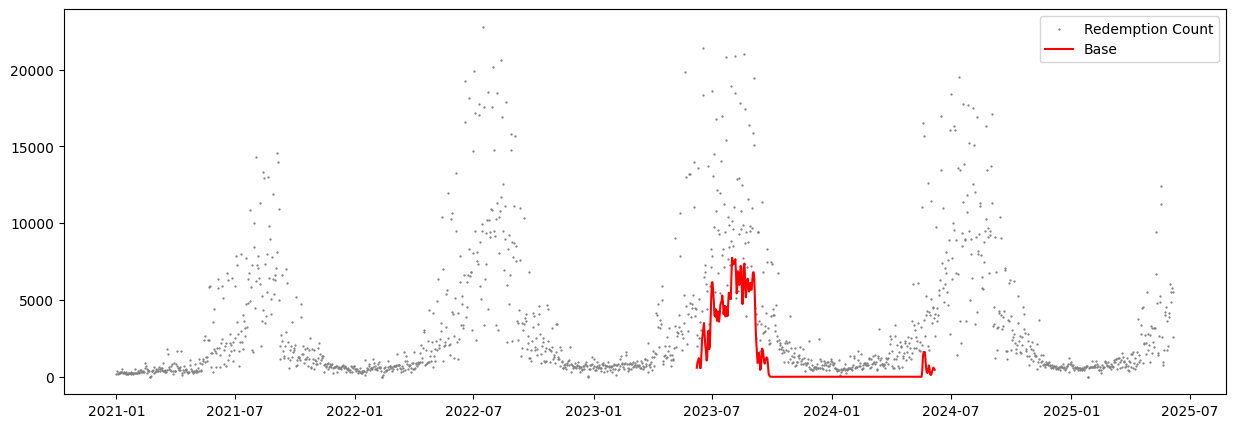

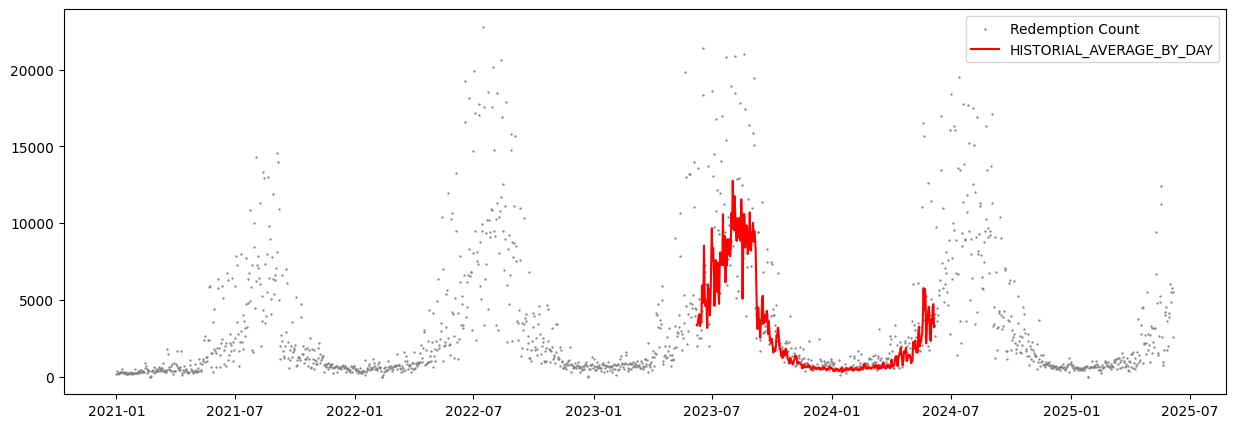

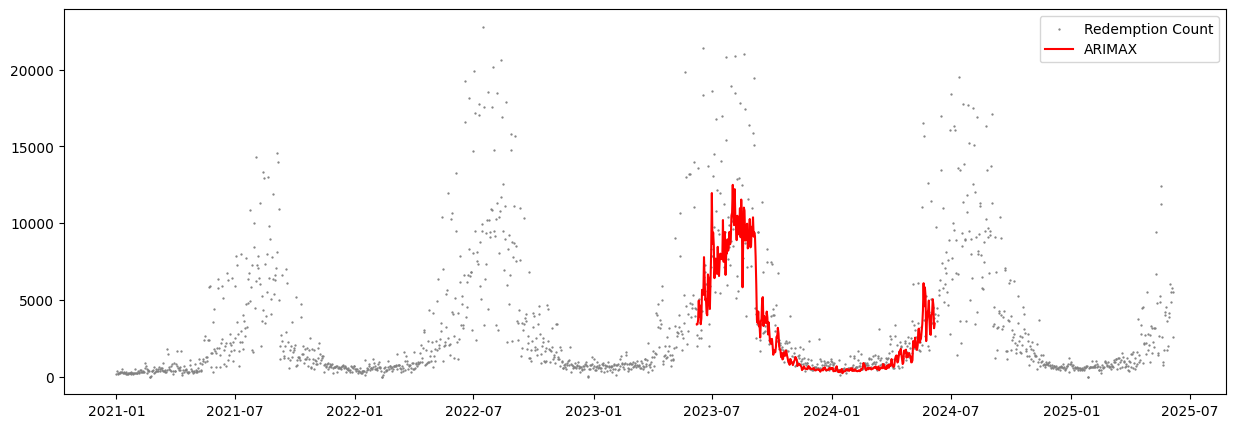

/Users/marianomaisonnave/Repositories/COMP-44081/.venv/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


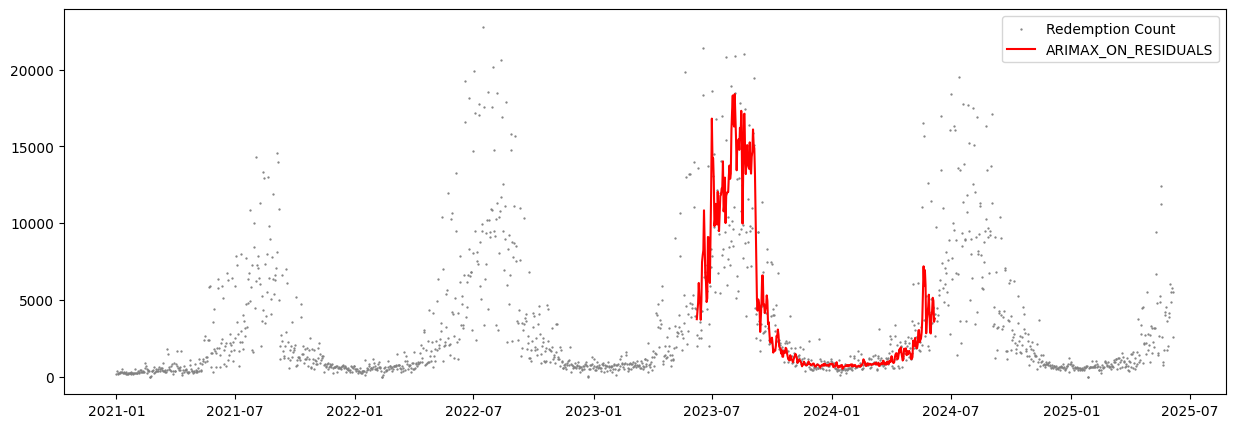

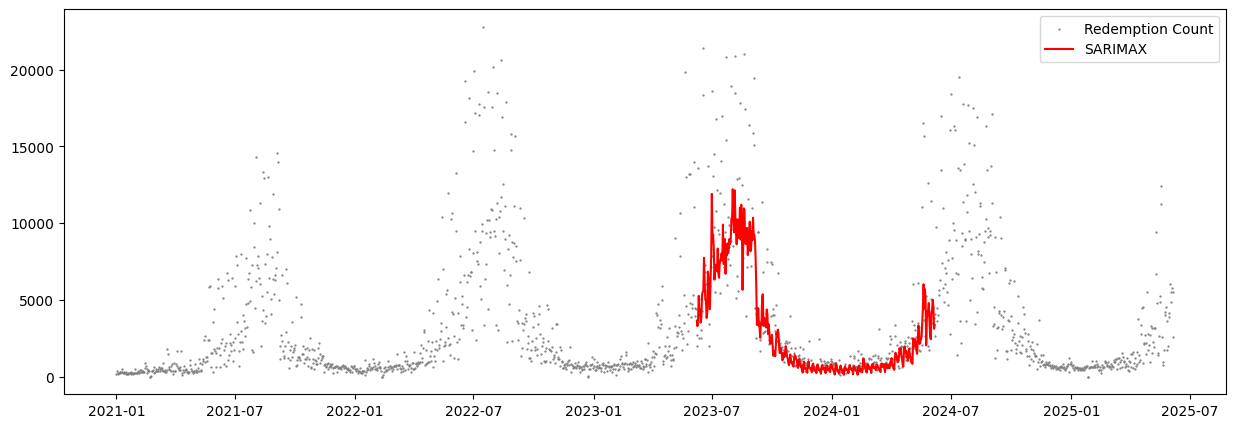

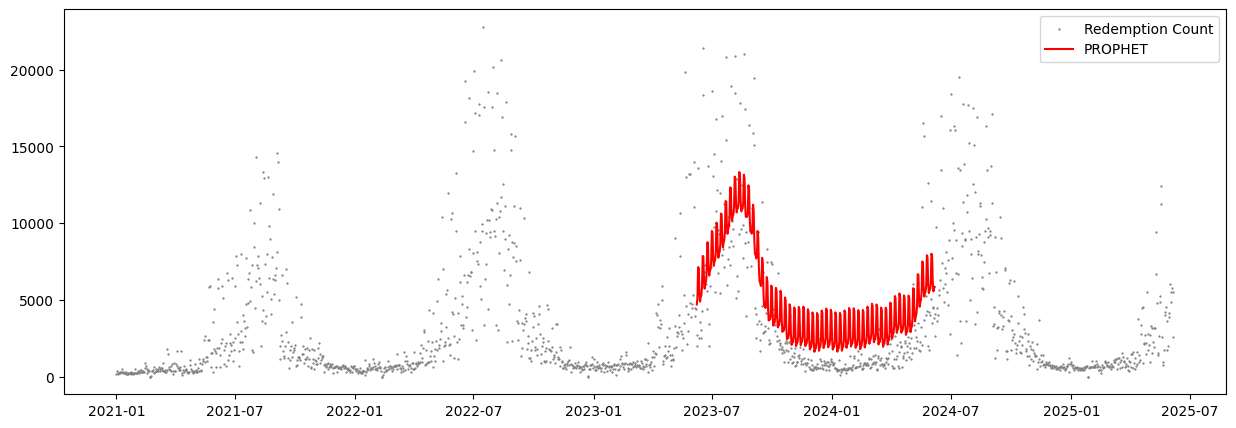

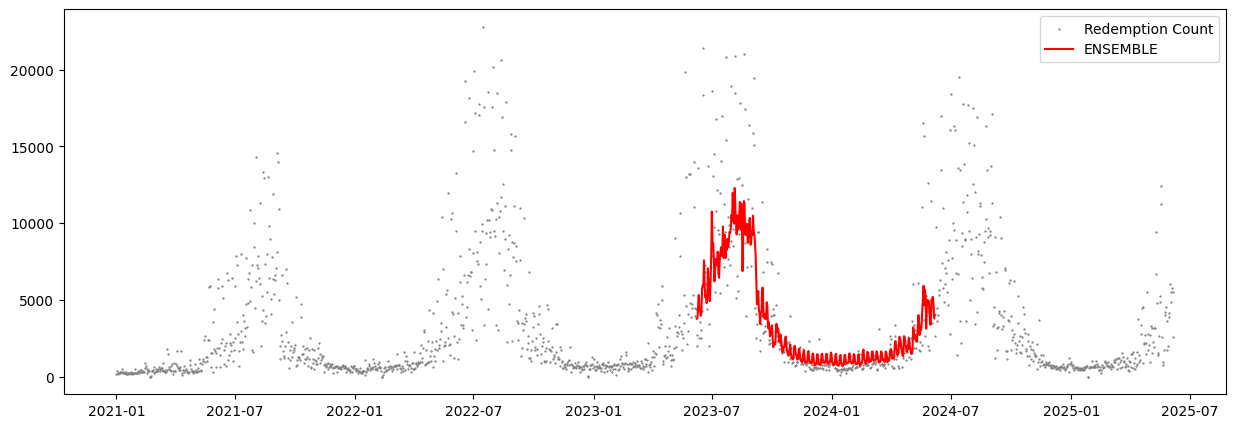

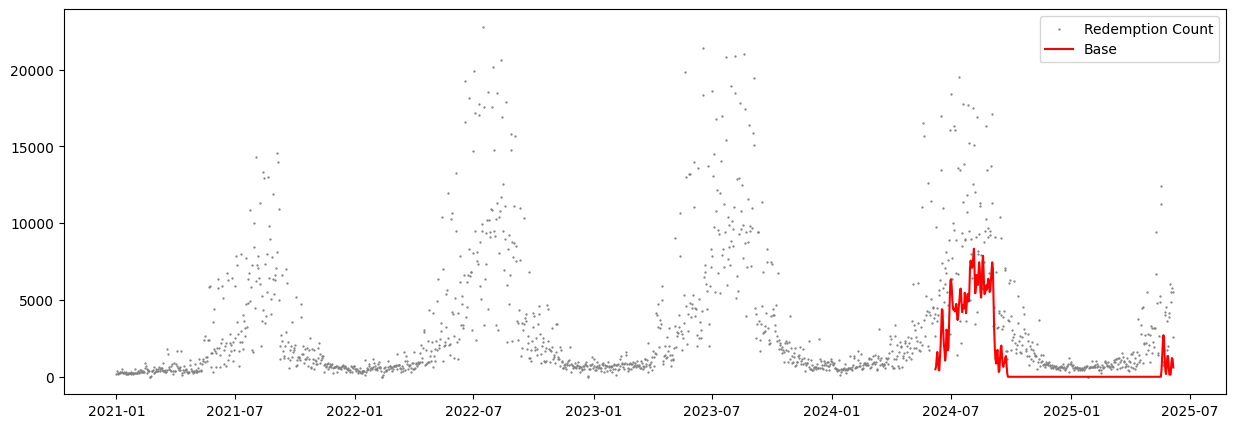

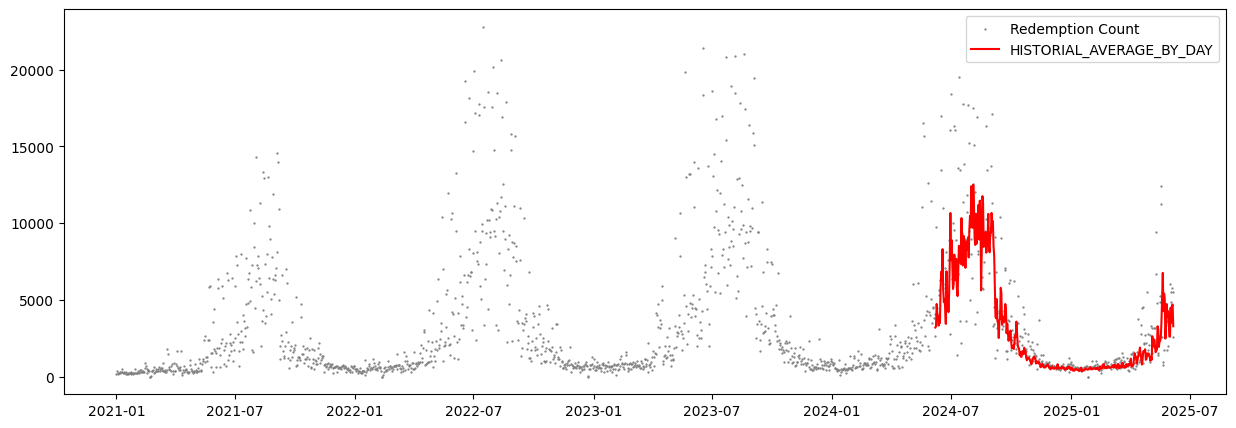

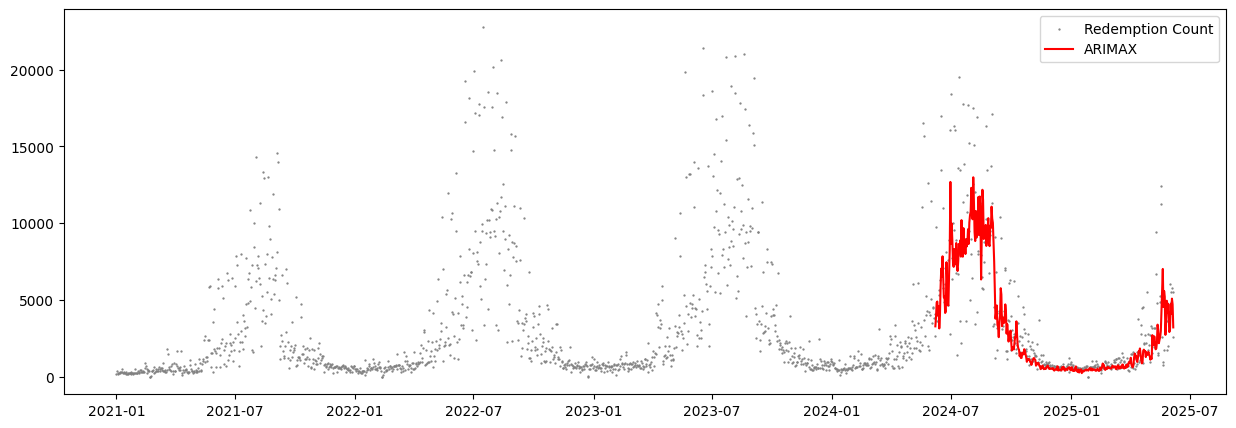

/Users/marianomaisonnave/Repositories/COMP-44081/.venv/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


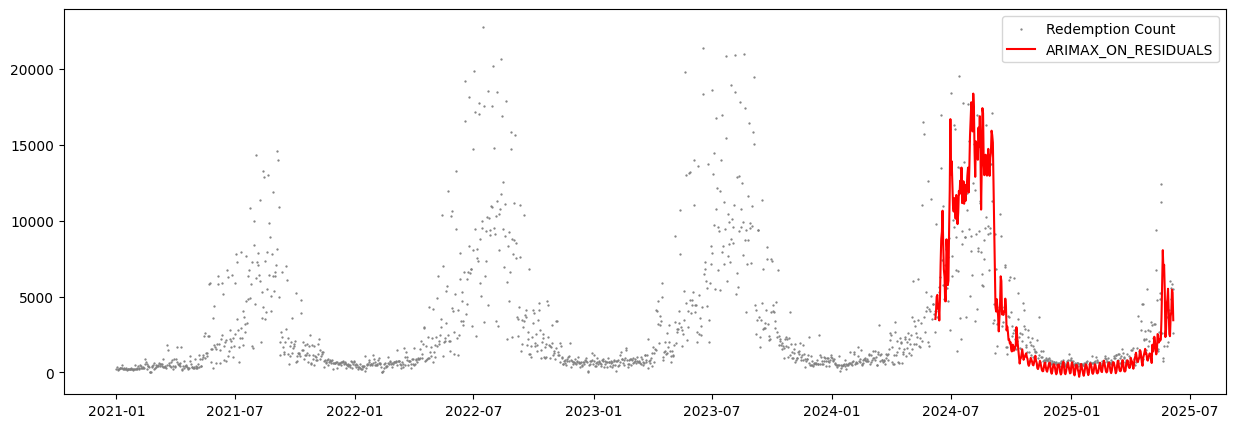

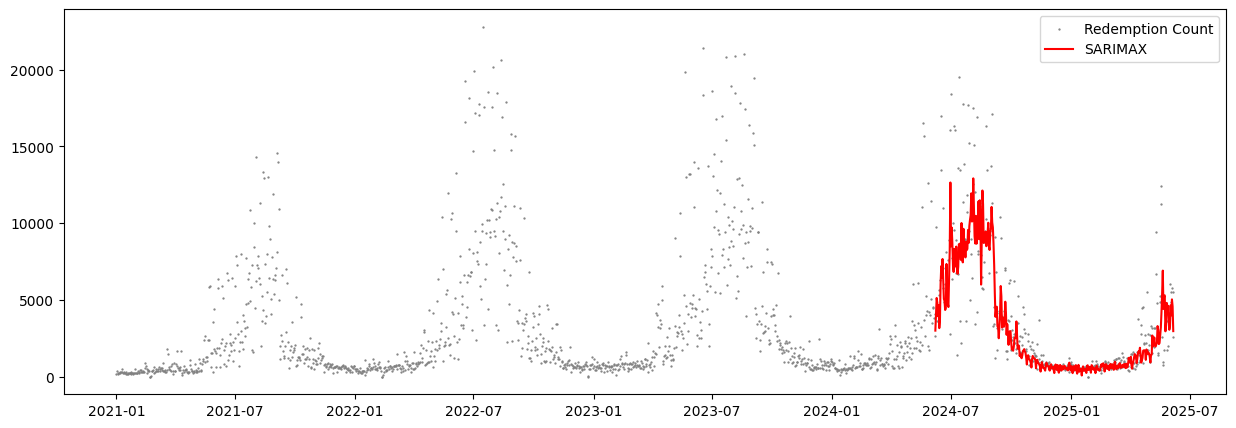

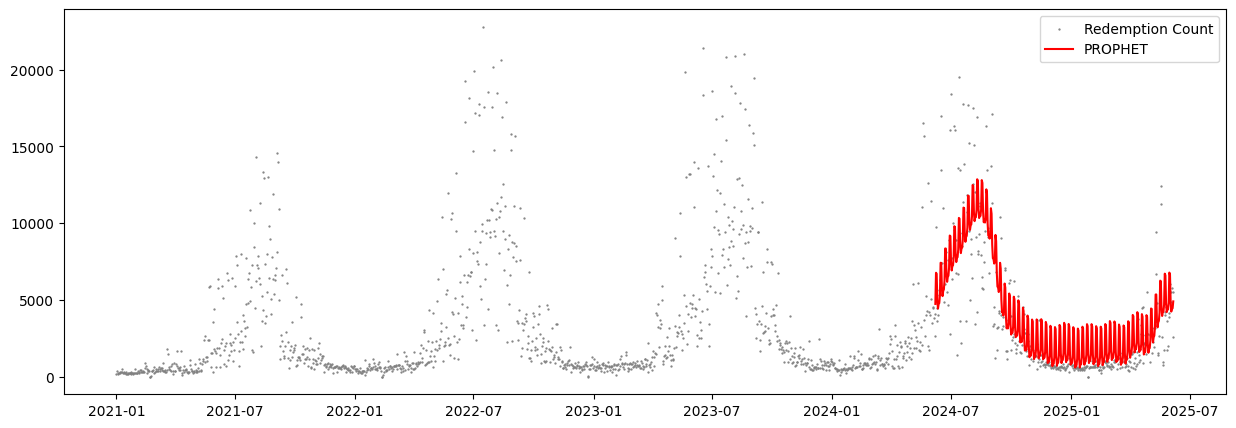

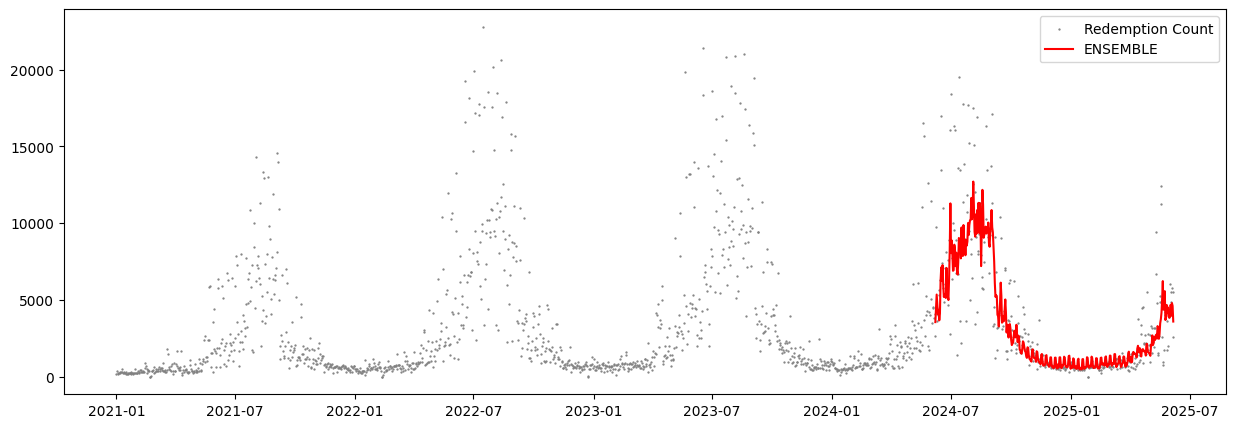

In [4]:
experiment_configuration = {
    'MODELS_TO_RUN': {
        'HISTORIAL_AVERAGE_BY_DAY', 
        'ARIMAX', 
        'ARIMAX_ON_RESIDUALS', 
        'SARIMAX', 
        'PROPHET', 
        'ENSEMBLE'
        },


    'ARIMAX': {'p': 7, 'd': 0, 'q': 2, 'exog_cols': ['Sales Count']},

    'ARIMAX_ON_RESIDUALS': {'p': 5, 'd': 1, 'q': 7,
                'exog_cols': ['Sales Count']},

    'SARIMAX': {'p': 1, 'd': 0, 'q': 0, 
                'P': 1, 'D': 1, 'Q': 1, 's': 7,
                'exog_cols': ['Sales Count']},

    'PROPHET': {
        'yearly_seasonality': True, 
        'daily_seasonality': False, 
        'weekly_seasonality': True
    },

    'ENSEMBLE': {'included-models': [
        # 'ARIMAX_ON_RESIDUALS', 
        'ARIMAX', 
        'SARIMAX',
        'HISTORIAL_AVERAGE_BY_DAY',
        'PROPHET',
        ],}
}
redemption_model = Model(df, 
           target_col='Redemption Count', 
           experiment_configuration=experiment_configuration,
           )
redemption_model.run_models()

In [5]:
import json
import numpy as np
from scipy.stats import t

def average_performance(results, ci=0.95):
    for model, splits in results.items():
        metrics = list(next(iter(splits.values())).keys())
        values = {metric: [] for metric in metrics}
        for split in splits.values():
            for metric in metrics:
                values[metric].append(split[metric])
        print(f"Model '{model}':")
        for metric in metrics:
            vals = np.array(values[metric])
            avg = np.mean(vals)
            std = np.std(vals, ddof=1)
            n = len(vals)
            if n > 1:
                se = std / np.sqrt(n)
                h = se * t.ppf((1 + ci) / 2., n-1)
                print(f"  {metric:4}: {avg:16,.4f}\tstd: {std:<16,.4f}\t{int(ci*100)}% CI: [{avg-h:,.4f}, {avg+h:,.4f}]")
            else:
                print(f"  {metric:4}: {avg:16,.4f} std: {std:16,.4f})")
        print()
average_performance(redemption_model.results)

# Save result to JSON   
with open('data/results_redemption_forecasting.json', 'w') as f:
    json.dump(redemption_model.results, f, indent=4, default=str)

Model 'Base':
  MAPE:           0.8652	std: 0.0194          	95% CI: [0.8344, 0.8961]
  MAE :       2,468.6425	std: 515.0849        	95% CI: [1,649.0275, 3,288.2574]
  MSE :  14,659,607.3346	std: 5,655,109.5214  	95% CI: [5,661,066.1334, 23,658,148.5358]

Model 'HISTORIAL_AVERAGE_BY_DAY':
  MAPE:           0.4769	std: 0.1360          	95% CI: [0.2605, 0.6932]
  MAE :       1,595.0007	std: 168.5410        	95% CI: [1,326.8144, 1,863.1870]
  MSE :   8,527,879.6253	std: 2,964,101.8111  	95% CI: [3,811,332.1967, 13,244,427.0540]

Model 'ARIMAX':
  MAPE:           0.4925	std: 0.1389          	95% CI: [0.2714, 0.7135]
  MAE :       1,564.0260	std: 134.4524        	95% CI: [1,350.0823, 1,777.9698]
  MSE :   7,975,429.4000	std: 2,459,029.7016  	95% CI: [4,062,564.4057, 11,888,294.3943]

Model 'ARIMAX_ON_RESIDUALS':
  MAPE:           0.6523	std: 0.2135          	95% CI: [0.3126, 0.9921]
  MAE :       1,919.3473	std: 198.4028        	95% CI: [1,603.6441, 2,235.0505]
  MSE :  10,771,477.8212	std: